In [2]:
pip install torchvision

  Using cached torchvision-0.19.1-cp312-cp312-win_amd64.whl.metadata (6.1 kB)
Using cached torchvision-0.19.1-cp312-cp312-win_amd64.whl (1.3 MB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define transformations for the training and validation datasets
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to the input size of AlexNet
        transforms.RandomHorizontalFlip(),  # Data augmentation
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Pre-trained models are trained on ImageNet
    ]),
    'valid': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Define directories for training and validation datasets
data_dir = 'animal'  # Change this to your dataset directory

# Create datasets
image_datasets = {x: datasets.ImageFolder(root=f'{data_dir}/{x}', transform=data_transforms[x])
                  for x in ['train', 'valid']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True)
               for x in ['train', 'valid']}


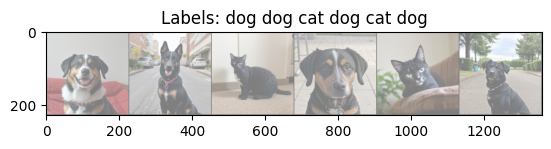

In [16]:
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms
import numpy as np

# Define transformations for displaying images
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

# Load datasets (assuming they are already organized in train and valid folders)
data_dir = 'animal'  # Replace with your dataset path
train_dataset = datasets.ImageFolder(root=data_dir + '/train', transform=transform)

# Create a DataLoader for the training dataset
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=6, shuffle=True)

# Function to show images
def imshow(imgs, labels):
    img_grid = torchvision.utils.make_grid(imgs)
    img_grid = img_grid / 2 + 0.5  # Unnormalize
    npimg = img_grid.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title("Labels: " + ' '.join(f'{train_dataset.classes[labels[j]]}' for j in range(len(labels))))
    plt.show()

# Get a batch of training data
images, labels = next(iter(train_loader))

# Show images
imshow(images, labels)


In [4]:
# Modify the classifier for binary classification
import torch
import torch.nn as nn
from torchvision import models

# Load the pre-trained AlexNet model
alexnet = models.alexnet(pretrained=True)

# Modify the classifier to output 2 classes for binary classification
num_ftrs = alexnet.classifier[6].in_features
alexnet.classifier[6] = nn.Linear(num_ftrs, 2)  # 2 classes for binary classification


C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\kumar/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth
100%|███████████████████████████████████████████████████████████████████████████████| 233M/233M [01:18<00:00, 3.11MB/s]


In [5]:
# Freeze all the convolutional base layers
for param in alexnet.features.parameters():
    param.requires_grad = False

In [6]:
import torch.optim as optim

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet = alexnet.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet.classifier.parameters(), lr=0.001)

# Training loop
def train_model(model, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # Backward pass and optimization
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return model

# Train the model
model_ft = train_model(alexnet, criterion, optimizer, num_epochs=10)

Epoch 1/10
----------
train Loss: 1.5709 Acc: 0.9150
valid Loss: 0.0000 Acc: 1.0000
Epoch 2/10
----------
train Loss: 0.6148 Acc: 0.9867
valid Loss: 0.0000 Acc: 1.0000
Epoch 3/10
----------
train Loss: 0.1567 Acc: 0.9967
valid Loss: 0.0000 Acc: 1.0000
Epoch 4/10
----------
train Loss: 0.1730 Acc: 0.9933
valid Loss: 0.0528 Acc: 0.9900
Epoch 5/10
----------
train Loss: 0.0432 Acc: 0.9950
valid Loss: 0.0000 Acc: 1.0000
Epoch 6/10
----------
train Loss: 0.1790 Acc: 0.9850
valid Loss: 0.0000 Acc: 1.0000
Epoch 7/10
----------
train Loss: 0.1004 Acc: 0.9933
valid Loss: 0.0000 Acc: 1.0000
Epoch 8/10
----------
train Loss: 0.0000 Acc: 1.0000
valid Loss: 0.0001 Acc: 1.0000
Epoch 9/10
----------
train Loss: 0.0000 Acc: 1.0000
valid Loss: 0.0000 Acc: 1.0000
Epoch 10/10
----------
train Loss: 0.0000 Acc: 1.0000
valid Loss: 0.0186 Acc: 0.9975


In [7]:
from sklearn.metrics import accuracy_score

# Evaluate the model performance on the validation set
def evaluate_model(model):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloaders['valid']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    print(f'Model accuracy on the validation set: {accuracy:.4f}')

# Evaluate the trained model
evaluate_model(model_ft)

Model accuracy on the validation set: 0.9975
